## Imports

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import from_json, col, count, window, avg, to_timestamp, min, max, last, to_json, struct
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DoubleType
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import socket

## Configuration Spark

In [2]:
def check_port(host, port):
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(5)  # Timeout de 5 secondes
    result = sock.connect_ex((host, port))
    if result == 0:
        print(f"Connexion réussie à {host}:{port}")
    else:
        print(f"Impossible de se connecter à {host}:{port}")
    sock.close()

check_port("kafka1", 9092)


Connexion réussie à kafka1:9092


In [3]:
conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")
 

sc = SparkContext.getOrCreate(conf=conf)


# Créer un SQLContext pour les opérations SQL
sql_context = SQLContext(sc)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f07c0dbd-6a45-4dcd-8a5b-64c06fc7b165;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	

## Schémas et Topics


In [4]:
kafka_broker = "kafka1:9092"
arrets_topic = "arrets"
velos_topic = "velos"
relais_topic = "relais"

# Définition du schéma pour le topic "arrets"
schema_arrets = StructType([
    StructField("codeLieu", StringType()),
    StructField("libelle", StringType()),
    StructField("distance", FloatType()),
    StructField("ligne", StringType())
])

# Définition du schéma pour le champ "position"
position_schema = StructType([
    StructField("lon", DoubleType()),
    StructField("lat", DoubleType())
])

# Définition du schéma pour le topic "velos"
schema_velos = StructType([
    StructField("number", StringType()),
    StructField("name", StringType()),
    StructField("address", StringType()),
    StructField("position", position_schema),
    StructField("banking", StringType()),
    StructField("bonus", StringType()),
    StructField("status", StringType()),
    StructField("contract_name", StringType()),
    StructField("bike_stands", IntegerType()),
    StructField("available_bike_stands", IntegerType()),
    StructField("available_bikes", IntegerType()),
    StructField("last_update", StringType())
])

# Définition du schéma pour le topic "relais"
schema_relais = StructType([
    StructField("grp_identifiant", StringType()),
    StructField("grp_nom", StringType()),
    StructField("grp_statut", IntegerType()),
    StructField("grp_disponible", IntegerType()),
    StructField("grp_exploitation", IntegerType()),
    StructField("grp_complet", IntegerType()),
    StructField("grp_horodatage", StringType()),
    StructField("idobj", StringType()),
    StructField("location", StructType([
        StructField("lon", DoubleType()),
        StructField("lat", DoubleType())
    ])),
    StructField("disponibilite", DoubleType())
])

# Définition du schéma pour le topic "parking_public"
schema_parking_public = StructType([
    StructField("grp_identifiant", StringType(), True),
    StructField("grp_nom", StringType(), True),
    StructField("grp_statut", StringType(), True),
    StructField("grp_disponible", IntegerType(), True),
    StructField("grp_exploitation", IntegerType(), True),
    StructField("grp_complet", IntegerType(), True),
    StructField("grp_horodatage", StringType(), True),
    StructField("idobj", StringType(), True),
    StructField("location", StructType([
         StructField("lon", DoubleType(), True),
         StructField("lat", DoubleType(), True)
    ]), True)
])

## Requête Batch sans fenêtre

Comptage des arrêts par ligne à partir du topic « arrets »

In [5]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", arrets_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" (encodé en JSON) en colonnes structurées
df_arrets = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_arrets).alias("data")) \
    .select("data.*")

# Agrégation : compter le nombre d'arrêts par "ligne"
result = df_arrets.groupBy("ligne").agg(count("*").alias("nb_arrets"))

# Affichage du résultat
result.show()
result.describe().show()

25/02/21 09:42:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+--------------------+---------+
|               ligne|nb_arrets|
+--------------------+---------+
|[{"numLigne":"119...|        7|
|[{"numLigne":"127...|        2|
|[{"numLigne":"10"...|        1|
|[{"numLigne":"107...|        3|
| [{"numLigne":"91"}]|       14|
|[{"numLigne":"75"...|        6|
|[{"numLigne":"50"...|        4|
|[{"numLigne":"30"...|        7|
| [{"numLigne":"79"}]|        6|
| [{"numLigne":"C3"}]|       12|
|[{"numLigne":"101...|        2|
| [{"numLigne":"30"}]|       12|
| [{"numLigne":"80"}]|       10|
|[{"numLigne":"112...|        1|
|[{"numLigne":"1"}...|        1|
|[{"numLigne":"28"...|        1|
|[{"numLigne":"172...|        2|
|[{"numLigne":"109...|        1|
|[{"numLigne":"104...|        1|
|[{"numLigne":"10"...|        1|
+--------------------+---------+
only showing top 20 rows



25/02/21 09:42:38 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------+--------------------+------------------+
|summary|               ligne|         nb_arrets|
+-------+--------------------+------------------+
|  count|                 434|               434|
|   mean|                NULL| 2.686635944700461|
| stddev|                NULL|3.2249684419313747|
|    min|                  []|                 1|
|    max|[{"numLigne":"NBI"}]|                28|
+-------+--------------------+------------------+



## Requête Batch avec fenêtre

Vélos disponibles par contrat sur des fenêtres temporelles à partir du topic « velos ».

In [6]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" en JSON
df_velos = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion de "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Agrégation par fenêtre (ici, on allonge la fenêtre à 30 minutes pour accumuler plusieurs mises à jour) et par station
result_window = df_velos.groupBy(
    window(col("last_update_ts"), "30 minutes"), 
    col("number"),
    col("contract_name")
).agg(
    count("*").alias("nb_updates"),
    last("available_bikes", ignorenulls=True).alias("latest_available_bikes")
)

result_window.show()

25/02/21 09:42:58 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+--------------------+------+-------------+----------+----------------------+
|              window|number|contract_name|nb_updates|latest_available_bikes|
+--------------------+------+-------------+----------+----------------------+
|{2025-02-19 18:00...|    38|       nantes|         1|                     0|
|{2025-02-19 18:00...|    51|       nantes|         1|                    15|
|{2025-02-19 18:00...|    19|       nantes|         1|                    15|
|{2025-02-19 18:00...|   125|       nantes|         1|                     5|
|{2025-02-19 18:00...|    77|       nantes|         1|                     1|
|{2025-02-19 18:30...|     5|       nantes|         7|                     3|
|{2025-02-19 18:30...|    15|       nantes|         7|                    16|
|{2025-02-19 18:30...|     1|       nantes|         9|                    13|
|{2022-05-23 14:30...|  1011|       nantes|       120|                     0|
|{2025-02-19 18:30...|    33|       nantes|         4|          

### Batch et visualisation graphique

25/02/21 09:43:23 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


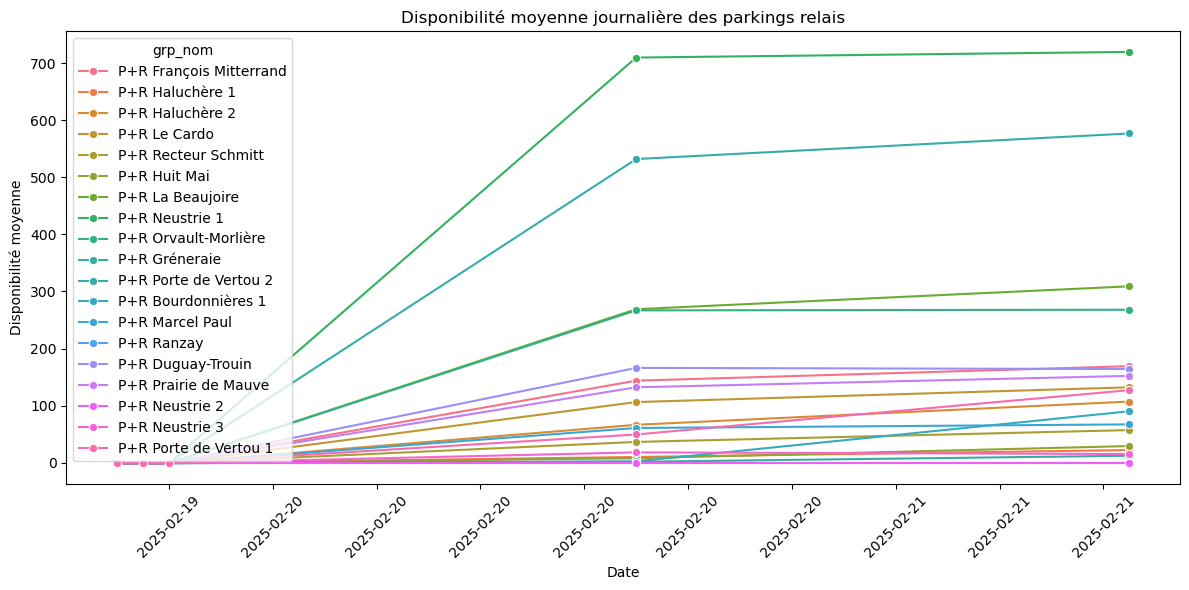

In [7]:
# Lecture batch depuis Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", relais_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du JSON
df_relais = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_relais).alias("data")) \
    .select("data.*")

# Conversion du champ de date en timestamp (format ISO 8601)
df_relais = df_relais.withColumn("horodatage_ts", 
                                  to_timestamp(col("grp_horodatage"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Agrégation : calcul de la disponibilité moyenne par parking sur une fenêtre d'1 jour
result = df_relais.groupBy(
    window(col("horodatage_ts"), "1 hour"),
    col("grp_identifiant"),
    col("grp_nom")
).agg(
    avg("disponibilite").alias("avg_disponibilite")
)

# Extraire la date de début de la fenêtre pour le graphique
result = result.withColumn("window_start", col("window.start")).drop("window")

# Conversion du résultat en DataFrame Pandas
pandas_df = result.toPandas()

# Tri des données par date et par parking
pandas_df.sort_values(by=["window_start", "grp_identifiant"], inplace=True)

# Visualisation avec Seaborn : une ligne par parking (grp_nom)
plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x="window_start", y="avg_disponibilite", hue="grp_nom", marker="o")
plt.title("Disponibilité moyenne journalière des parkings relais")
plt.xlabel("Date")
plt.ylabel("Disponibilité moyenne")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Requêtes Streaming

### Récuperer la moyenne des disponiblités des parkings relais sur une fenêtre glissante.

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", relais_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_relais = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_relais).alias("data")) \
    .select("data.*")

# Conversion du champ "grp_horodatage" en timestamp
# Le format ISO 8601 est utilisé : "yyyy-MM-dd'T'HH:mm:ssXXX"
df_relais = df_relais.withColumn("horodatage_ts", 
                                  to_timestamp(col("grp_horodatage"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Définition d'un watermark de 5 minutes pour gérer les retards éventuels
df_relais = df_relais.withWatermark("horodatage_ts", "5 minutes")

# Agrégation : calcul de la moyenne des disponibilités sur une fenêtre glissante
# Ici, la fenêtre est de 5 minutes et on agrège par "grp_identifiant"
result_stream = df_relais.groupBy(
    window(col("horodatage_ts"), "5 minutes"),
    col("grp_identifiant"),
).agg(
    avg("disponibilite").alias("avg_disponibilite")
)

# Écriture du résultat en streaming vers la console (mode "update")
query = result_stream.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query.awaitTermination()

In [ ]:
query.stop()

### Récuperer la moyenne des vélos disponibles par parking sur une fenêtre glissante.

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka_velos = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_velos = df_kafka_velos.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion du champ "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Application d'un watermark de 5 minutes pour gérer les retards
df_velos = df_velos.withWatermark("last_update_ts", "5 minutes")

# Agrégation sur une fenêtre de 5 minutes : calcul du total des places disponibles
result_velos = df_velos.groupBy(
    window(col("last_update_ts"), "5 minutes"),
    col("name")
).agg(
    avg("available_bikes").alias("moyenne_velos_disponibles")
)

# Écriture du résultat en streaming vers la console (mode "update")
query_velos = result_velos.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query_velos.awaitTermination()

In [ ]:
query_velos.stop()

## Streaming vers le dashboard

### Velos disponibles

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka_velos = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_velos = df_kafka_velos.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion du champ "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Application d'un watermark de 5 minutes pour gérer les retards
df_velos = df_velos.withWatermark("last_update_ts", "5 minutes")

# Agrégation sur une fenêtre de 5 minutes : calcul du total des places disponibles
result_velos = df_velos.groupBy(
    window(col("last_update_ts"), "5 minutes"),
    col("name")
).agg(
    avg("available_bikes").alias("moyenne_velos_disponibles")
)

# Préparation des données pour l'écriture dans Kafka
dashboard_df = result_velos.select(
    col("name").cast("string").alias("key"),
    to_json(struct(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("name"),
        col("moyenne_velos_disponibles")
    )).alias("value")
)

# Écriture du résultat en streaming vers le topic Kafka "velos_dashboard"
query_velos = dashboard_df.writeStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("topic", "dashvelos") \
    .option("checkpointLocation", "/tmp/checkpoint_velos") \
    .outputMode("update") \
    .start()

query_velos.awaitTermination()

In [ ]:
query_velos.stop()

### Relais

In [5]:
# Lecture en streaming depuis Kafka pour le topic relais
df_kafka = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", relais_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_relais = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_relais).alias("data")) \
    .select("data.*")

# Conversion du champ "grp_horodatage" en timestamp
df_relais = df_relais.withColumn("horodatage_ts", 
                                  to_timestamp(col("grp_horodatage"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Définition d'un watermark de 5 minutes pour gérer les retards éventuels
df_relais = df_relais.withWatermark("horodatage_ts", "5 minutes")

# Agrégation sur une fenêtre de 5 minutes par identifiant : calcul de la moyenne des disponibilités
result_stream = df_relais.groupBy(
    window(col("horodatage_ts"), "5 minutes"),
    col("grp_identifiant")
).agg(
    avg("disponibilite").alias("avg_disponibilite")
)

# Préparation des données pour l'écriture dans Kafka :
# On crée une colonne "key" avec grp_identifiant et une colonne "value" contenant un JSON.
dashboard_relais_df = result_stream.select(
    col("grp_identifiant").cast("string").alias("key"),
    to_json(struct(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("grp_identifiant"),
        col("avg_disponibilite")
    )).alias("value")
)

# Écriture du résultat en streaming vers le topic Kafka "dashrelais"
query_relais = dashboard_relais_df.writeStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("topic", "dashrelais") \
    .option("checkpointLocation", "/tmp/checkpoint_relais") \
    .outputMode("update") \
    .start()

query_relais.awaitTermination()

25/02/20 14:08:51 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/02/20 14:08:52 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardIn

KeyboardInterrupt: 

25/02/20 17:29:20 WARN KafkaOffsetReaderAdmin: Error in attempt 1 getting Kafka offsets: 
java.util.concurrent.ExecutionException: org.apache.kafka.common.errors.TimeoutException: Timed out waiting for a node assignment. Call: listOffsets on broker 1
	at java.base/java.util.concurrent.CompletableFuture.reportGet(CompletableFuture.java:396)
	at java.base/java.util.concurrent.CompletableFuture.get(CompletableFuture.java:2073)
	at org.apache.kafka.common.internals.KafkaFutureImpl.get(KafkaFutureImpl.java:165)
	at org.apache.spark.sql.kafka010.KafkaOffsetReaderAdmin.listOffsets(KafkaOffsetReaderAdmin.scala:88)
	at org.apache.spark.sql.kafka010.KafkaOffsetReaderAdmin.$anonfun$fetchLatestOffsets$1(KafkaOffsetReaderAdmin.scala:332)
	at org.apache.spark.sql.kafka010.KafkaOffsetReaderAdmin.$anonfun$partitionsAssignedToAdmin$1(KafkaOffsetReaderAdmin.scala:501)
	at org.apache.spark.sql.kafka010.KafkaOffsetReaderAdmin.withRetries(KafkaOffsetReaderAdmin.scala:518)
	at org.apache.spark.sql.kafka010.

In [ ]:
query_relais.stop()

## MultiTopic Query

In [8]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .appName("SparkApp2") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .getOrCreate()

def read_kafka_stream(topic, schema, is_streaming=True):
    if is_streaming:
        df = spark.readStream.format("kafka") \
            .option("kafka.bootstrap.servers", kafka_broker) \
            .option("subscribe", topic) \
            .option("startingOffsets", "earliest") \
            .load()
    else:
        df = spark.read.format("kafka") \
            .option("kafka.bootstrap.servers", kafka_broker) \
            .option("subscribe", topic) \
            .option("startingOffsets", "earliest") \
            .load()
    # Convert the binary "value" column to string and parse JSON using the provided schema.
    df = df.selectExpr("CAST(value AS STRING) as json_string")
    df = df.select(F.from_json(F.col("json_string"), schema).alias("data")).select("data.*")
    return df


25/02/21 09:44:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [12]:
!spark-submit --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1 your_script.py

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8be827f5-bff1-493f-a732-6212ad8a56d6;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.2.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.2.1 in central
	found org.apache.kafka#kafka-clients;2.8.0 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.1 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.1 in central
	found org.apache.htrace#h

In [9]:
df_arrets = read_kafka_stream(arrets_topic, schema_arrets, is_streaming=False)
df_velos = read_kafka_stream(velos_topic, schema_velos, is_streaming=False)
df_relais = read_kafka_stream(relais_topic, schema_relais, is_streaming=False)
df_parking = read_kafka_stream("parking_public", schema_parking_public, is_streaming=False)

In [14]:
from pyspark.sql import functions as F
from math import radians, sin, cos, sqrt, atan2


# Define Python function
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 6371 * 2 * atan2(sqrt(a), sqrt(1-a))  # Earth radius in km

# Create Spark UDF
haversine_udf = F.udf(haversine, DoubleType())

# Register for SparkSQL
spark.udf.register("haversine", haversine_udf)

25/02/21 09:48:07 WARN SimpleFunctionRegistry: The function haversine replaced a previously registered function.


In [15]:
parking_bike_analysis = (
    df_parking.alias("parking")
    .filter(F.col("parking.grp_complet") != 1)
    .join(
        df_velos.alias("velo"),
        [
            (F.abs(F.col("parking.location.lon") - F.col("velo.position.lon")) <= 0.01),
            (F.abs(F.col("parking.location.lat") - F.col("velo.position.lat")) <= 0.01)
        ]
    )
    .withColumn("distance_km", haversine_udf(
        F.col("parking.location.lon"), 
        F.col("parking.location.lat"),
        F.col("velo.position.lon"),
        F.col("velo.position.lat")
    ))
    .filter(F.col("distance_km") <= 0.5)
    .groupBy("parking.grp_identifiant")
    .agg(
        F.avg("velo.available_bikes").alias("avg_bikes"),
        F.count_distinct("velo.number").alias("nearby_stations"),
        F.first("parking.location.lon").alias("parking_lon"),
        F.first("parking.location.lat").alias("parking_lat"),
        F.first("parking.grp_nom").alias("parking_grp_nom")  # Get parking's own name
    )
    .join(
        df_relais.alias("relais"), 
        "grp_identifiant", 
        "left"
    )
    .select(
        F.coalesce(
            "relais.grp_nom", 
            "parking_grp_nom", 
            F.concat(F.lit("Parking "), "grp_identifiant")
        ).alias("location_name"),  # Fixed parenthesis and alias position
        "avg_bikes",
        "nearby_stations",
        F.coalesce("relais.location.lon", "parking_lon").alias("lon"),
        F.coalesce("relais.location.lat", "parking_lat").alias("lat")
    )
)

parking_bike_analysis.show(truncate=False)

25/02/21 09:48:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 09:48:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 09:48:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----------------------+------------------+---------------+-------------------+------------------+
|location_name         |avg_bikes         |nearby_stations|lon                |lat               |
+----------------------+------------------+---------------+-------------------+------------------+
|Feydeau               |7.957361758827449 |15             |-1.552558781000016 |47.21407529499999 |
|Decré-Bouffay         |7.809766022380468 |17             |-1.5540046290000191|47.21666261299998 |
|Tour Bretagne         |9.498575498575498 |20             |-1.5582500169999776|47.21784288800001 |
|Graslin               |10.693508627773213|13             |-1.562571814000023 |47.214310205000004|
|Aristide Briand       |11.393553223388306|14             |-1.5629364160000137|47.21709359800002 |
|Médiathèque           |8.078271028037383 |10             |-1.56233817399999  |47.210870821000015|
|Commerce              |9.235294117647058 |15             |-1.557713217000014 |47.21312028       |
|Talensac 

In [16]:
parking_velos_deficit = (
    df_parking.alias("parking")
    .filter(F.col("grp_complet") != 1)
    .join(
         df_velos.alias("velo"),
         (F.abs(F.col("parking.location.lon") - F.col("velo.position.lon")) <= 0.01) &
         (F.abs(F.col("parking.location.lat") - F.col("velo.position.lat")) <= 0.01)
    )
    .withColumn("bike_deficit", F.col("velo.bike_stands") - F.col("velo.available_bikes"))
    .groupBy("parking.grp_identifiant", "parking.grp_nom")
    .agg(
         F.avg("bike_deficit").alias("avg_bike_deficit"),
         F.sum("velo.available_bikes").alias("total_available_bikes")
    )
)

parking_velos_deficit.show(truncate=False)

25/02/21 09:49:54 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 09:49:54 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+---------------+----------------------+------------------+---------------------+
|grp_identifiant|grp_nom               |avg_bike_deficit  |total_available_bikes|
+---------------+----------------------+------------------+---------------------+
|040            |Fonderies             |13.435897435897436|366158               |
|009            |Cité des Congrès      |14.66044029352902 |607022               |
|006            |Médiathèque           |12.215535524920467|868244               |
|001            |Feydeau               |13.697695642254164|976170               |
|021            |Gare Nord             |14.528272414870353|650676               |
|008            |Talensac              |9.853158137390503 |987142               |
|005            |Aristide Briand       |10.329298418972332|958412               |
|016            |Gare Sud 2 : Limité 1h|16.054361567635905|462696               |
|002            |Decré-Bouffay         |11.756201881950386|970398               |
|044            

In [19]:
from pyspark.sql.window import Window

parking_ranking = (
    read_kafka_stream(relais_topic, schema_relais, False).alias("relais")
    .crossJoin(read_kafka_stream(velos_topic, schema_velos, False).alias("velo"))
    .withColumn("distance_km", haversine_udf(
        F.col("relais.location.lon"),
        F.col("relais.location.lat"),
        F.col("velo.position.lon"),
        F.col("velo.position.lat")
    ))
    .filter(F.col("distance_km") <= 0.5)
    .groupBy("relais.grp_identifiant", "relais.grp_nom")
    .agg(
        F.avg("velo.available_bikes").alias("avg_bikes"),
        F.count_distinct("velo.number").alias("num_stations")
    )
    .withColumn("rank", 
               F.dense_rank().over(Window.orderBy(F.desc("avg_bikes")))
    )
    .orderBy("rank")
)

parking_ranking.show(truncate=False)

25/02/21 09:53:26 WARN ExtractPythonUDFFromJoinCondition: The join condition:(haversine(location#1598.lon, location#1598.lat, position#1631.lon, position#1631.lat)#1674 <= 0.5) of the join plan contains PythonUDF only, it will be moved out and the join plan will be turned to cross join.
25/02/21 09:53:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 09:53:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 09:53:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/21 09:53:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance d

+---------------+-------------+------------------+------------+----+
|grp_identifiant|grp_nom      |avg_bikes         |num_stations|rank|
+---------------+-------------+------------------+------------+----+
|140            |P+R Huit Mai |14.157303370786517|2           |1   |
|144            |P+R Gréneraie|6.155963302752293 |2           |2   |
+---------------+-------------+------------------+------------+----+



### Avec affichage graphique

25/02/21 09:56:45 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 09:56:45 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


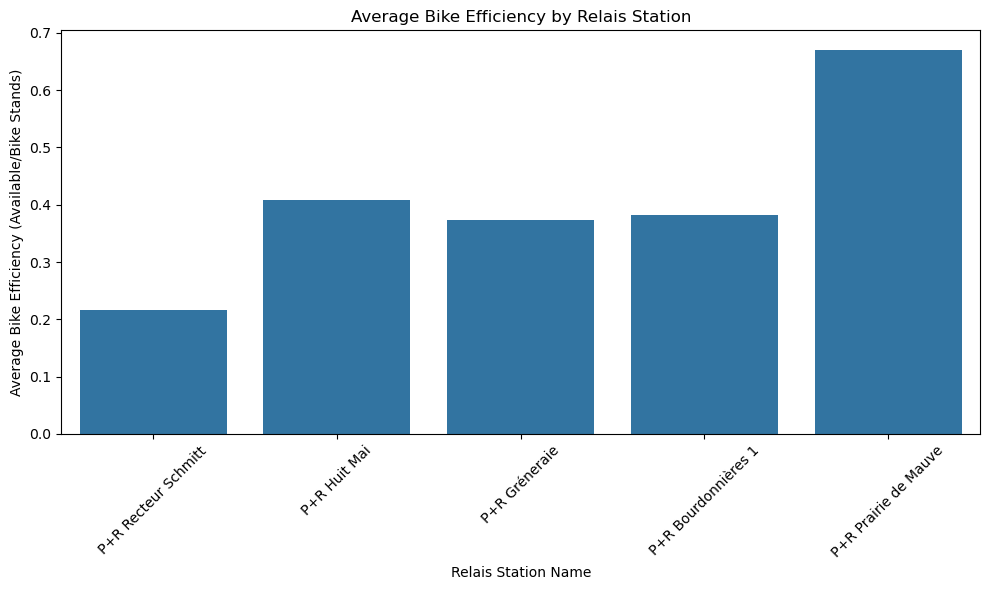

In [20]:
relays_efficiency = (
    df_relais.alias("rel")
    .join(
         df_velos.alias("velo"),
         (F.abs(F.col("rel.location.lon") - F.col("velo.position.lon")) <= 0.01) &
         (F.abs(F.col("rel.location.lat") - F.col("velo.position.lat")) <= 0.01)
    )
    .withColumn("bike_efficiency", F.col("velo.available_bikes") / F.col("velo.bike_stands"))
    .groupBy("rel.grp_nom")
    .agg(F.avg("bike_efficiency").alias("avg_bike_efficiency"))
)

relays_efficiency_pd = relays_efficiency.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=relays_efficiency_pd, x="grp_nom", y="avg_bike_efficiency")
plt.title("Average Bike Efficiency by Relais Station")
plt.xlabel("Relais Station Name")
plt.ylabel("Average Bike Efficiency (Available/Bike Stands)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Spark SQL

In [17]:
df_parking.createOrReplaceTempView("parking")
df_velos.createOrReplaceTempView("velos")

result = spark.sql("""
SELECT 
    p.grp_identifiant,
    p.grp_nom,
    COUNT(DISTINCT v.number) AS nearby_bike_stations,
    AVG(v.available_bikes) AS avg_available_bikes
FROM parking p
JOIN velos v
  ON ABS(p.location.lon - v.position.lon) <= 0.01
     AND ABS(p.location.lat - v.position.lat) <= 0.01
WHERE p.grp_complet <> 1
GROUP BY p.grp_identifiant, p.grp_nom
ORDER BY avg_available_bikes DESC
""")

result.show(truncate=False)


25/02/21 09:51:29 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 09:51:29 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+---------------+---------------+--------------------+-------------------+
|grp_identifiant|grp_nom        |nearby_bike_stations|avg_available_bikes|
+---------------+---------------+--------------------+-------------------+
|044            |Gare Sud 2     |17                  |9.629604365620736  |
|012            |Descartes      |38                  |9.2499322309569    |
|004            |Graslin        |43                  |9.12351658997336   |
|005            |Aristide Briand|41                  |9.106225296442688  |
|037            |Gloriette 2    |39                  |9.058586401504972  |
|029            |Bellamy        |38                  |8.913513513513514  |
|006            |Médiathèque    |39                  |8.853128313891835  |
|010            |Cathédrale     |42                  |8.799610894941635  |
|008            |Talensac       |42                  |8.752189949285386  |
|015            |Hôtel Dieu     |41                  |8.567834237789837  |
|001            |Feydeau 